In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Final_dataset.csv", on_bad_lines='skip', engine='python')

In [ ]:
data=df[['statement','status']]
display(data.head(20))

,statement,status
0,"['oh', 'my', 'gosh']",Anxiety
1,"['trouble', 'sleep', 'confused', 'mind', 'rest...",Anxiety
2,"['all', 'wrong', 'back', 'off', 'dear', 'forwa...",Anxiety
3,"['I', 've', 'shift', 'my', 'focus', 'to', 'som...",Anxiety
4,"['I', 'm', 'restless', 'and', 'restless', 'its...",Anxiety
5,"['every', 'break', 'you', 'must', 'be', 'nervo...",Anxiety
6,"['I', 'feel', 'scared', 'anxious', 'what', 'ca...",Anxiety
7,"['have', 'you', 'ever', 'feel', 'nervous', 'bu...",Anxiety
8,"['I', 'have', 'not', 'sleep', 'well', 'for', '...",Anxiety
9,"['I', 'm', 'really', 'worried', 'I', 'want', '...",Anxiety


In [ ]:
data.status.value_counts()
#count frequency of each label category

,count
status,
Normal,16020
Depression,15086
Suicidal,10641
Anxiety,3613
Bipolar,2501
Stress,2293
Personality disorder,895


In [ ]:
from sklearn.utils import resample

df_sample = df.sample(n=min(20000, len(df)), random_state=42)

if 0 in df_sample['status'].values:
    majority_size = len(df_sample[df_sample['status']==0])
else:
    class_counts = df_sample['status'].value_counts()
    majority_size = class_counts.iloc[0]
    print(f"Status 0 not found in sample. Using majority class size: {majority_size}")

def resampling(df_subset, target_size):
    """Resample a dataframe subset to target size"""
    if len(df_subset) == 0:
        return df_subset
    if len(df_subset) >= target_size:
        return df_subset.sample(n=target_size, random_state=42, replace=False)
    else:
        return resample(df_subset, replace=True, n_samples=target_size, random_state=42)

unique_statuses = sorted(df_sample['status'].unique())
print(f"\nUnique status values in sample: {unique_statuses}")

resampled_dfs = []
for status_val in unique_statuses:
    df_class = df_sample[df_sample['status'] == status_val]
    resampled_df = resampling(df_class, majority_size)
    print(f"Status {status_val}: Original {len(df_class)} → Resampled {len(resampled_df)}")
    resampled_dfs.append(resampled_df)

df_new = pd.concat(resampled_dfs, axis=0).reset_index(drop=True)

print("\nAfter resampling class distribution:")
print(df_new['status'].value_counts())
print(f"\nTotal samples: {len(df_new)}")

data = df_new[['statement','status']]

Status 0 not found in sample. Using majority class size: 6353

Unique status values in sample: ['Anxiety', 'Bipolar', 'Depression', 'Normal', 'Personality disorder', 'Stress', 'Suicidal']
Status Anxiety: Original 1389 → Resampled 6353
Status Bipolar: Original 1019 → Resampled 6353
Status Depression: Original 5912 → Resampled 6353
Status Normal: Original 6353 → Resampled 6353
Status Personality disorder: Original 340 → Resampled 6353
Status Stress: Original 886 → Resampled 6353
Status Suicidal: Original 4101 → Resampled 6353

After resampling class distribution:
status
Anxiety                 6353
Bipolar                 6353
Depression              6353
Normal                  6353
Personality disorder    6353
Stress                  6353
Suicidal                6353
Name: count, dtype: int64

Total samples: 44471


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['status_encoded'] = label_encoder.fit_transform(data['status'])

In [ ]:
print("\nLabel encoding mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label encoding mapping:
Anxiety: 0
Bipolar: 1
Depression: 2
Normal: 3
Personality disorder: 4
Stress: 5
Suicidal: 6


In [ ]:
X = data['statement']
y = data['status_encoded']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 35576
Test set size: 8895


FastText is a word embedding technique developed by Facebook AI Research. Unlike traditional word2vec, FastText represents each word as a bag of character n-grams, which helps it understand:

Subword information (prefixes, suffixes, roots)

Morphological variations (running, runs, ran)

Misspelled words

Rare/out-of-vocabulary words


In [ ]:
!pip install gensim

from gensim.models import FastText
import numpy as np


sentences = [sentence.split() for sentence in X_train]

ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [ft_model.wv[word] for word in words]

    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_vec = np.array([vectorize(sentence) for sentence in X_train])
X_test_vec = np.array([vectorize(sentence) for sentence in X_test])


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score



In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [ ]:
train_dataset = SentimentDataset(X_train_vec, y_train)
test_dataset = SentimentDataset(X_test_vec, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # add sequence dimension
        out, h_n = self.rnn(x)
        out = self.fc(h_n.squeeze(0))  # use last hidden state
        return out


In [ ]:
input_size = X_train_vec.shape[1]
hidden_size = 128
num_classes = len(label_encoder.classes_)

model = RNNClassifier(input_size, hidden_size, num_classes)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs =100

In [ ]:

train_losses = []
train_accuracies = []


In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_running_loss += loss.item() * X_batch.size(0)

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == y_batch).sum().item()
            test_total += y_batch.size(0)

    test_loss = test_running_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f" → Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1/100, Train Loss: 1.2983, Train Acc: 0.5459
 → Test Loss: 1.0927, Test Acc: 0.6162
Epoch 2/100, Train Loss: 1.0273, Train Acc: 0.6348
 → Test Loss: 1.0031, Test Acc: 0.6399
Epoch 3/100, Train Loss: 0.9861, Train Acc: 0.6533
 → Test Loss: 0.9754, Test Acc: 0.6569
Epoch 4/100, Train Loss: 0.9636, Train Acc: 0.6578
 → Test Loss: 0.9673, Test Acc: 0.6581
Epoch 5/100, Train Loss: 0.9476, Train Acc: 0.6645
 → Test Loss: 0.9382, Test Acc: 0.6689
Epoch 6/100, Train Loss: 0.9398, Train Acc: 0.6681
 → Test Loss: 0.9356, Test Acc: 0.6673
Epoch 7/100, Train Loss: 0.9306, Train Acc: 0.6686
 → Test Loss: 0.9331, Test Acc: 0.6718
Epoch 8/100, Train Loss: 0.9232, Train Acc: 0.6707
 → Test Loss: 0.9105, Test Acc: 0.6753
Epoch 9/100, Train Loss: 0.9150, Train Acc: 0.6723
 → Test Loss: 0.9255, Test Acc: 0.6711
Epoch 10/100, Train Loss: 0.9096, Train Acc: 0.6743
 → Test Loss: 0.9057, Test Acc: 0.6777
Epoch 11/100, Train Loss: 0.9057, Train Acc: 0.6755
 → Test Loss: 0.9150, Test Acc: 0.6643
Epoch 12

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

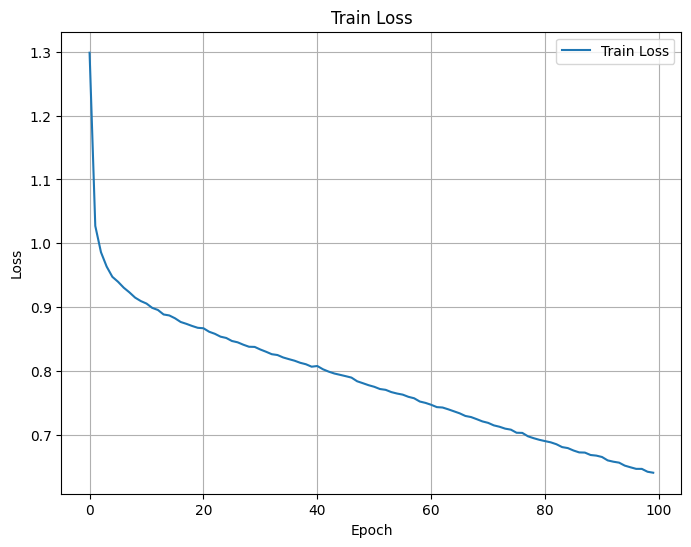

In [ ]:

plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.grid(True)
plt.show()


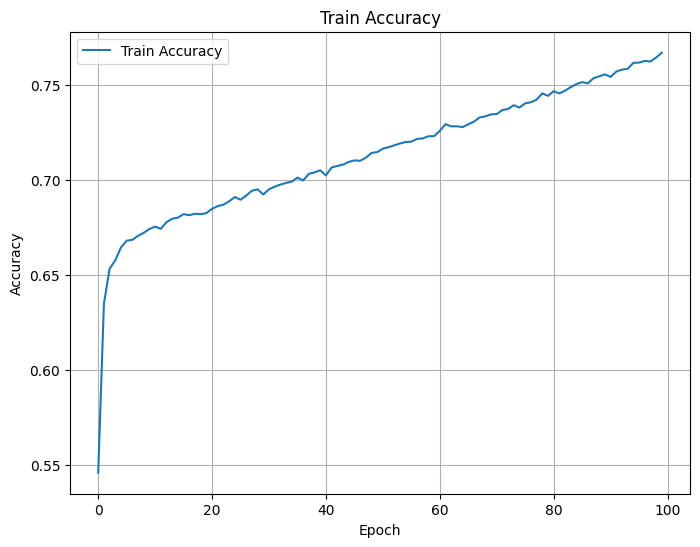

In [ ]:

plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train Accuracy")
plt.legend()
plt.grid(True)
plt.show()



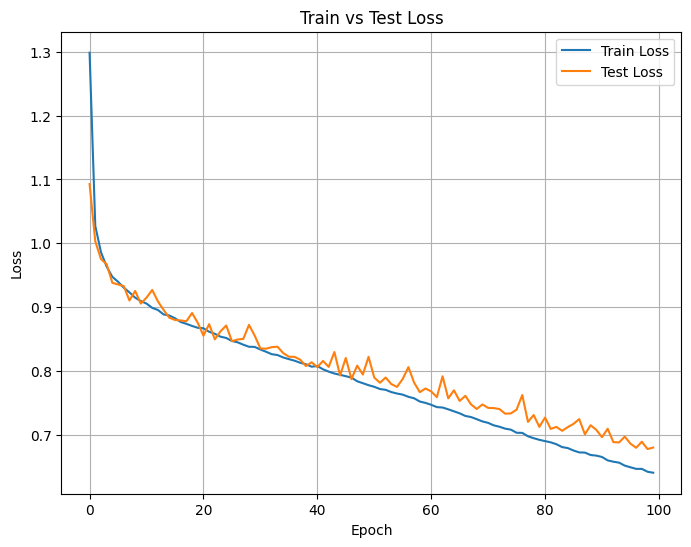

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()


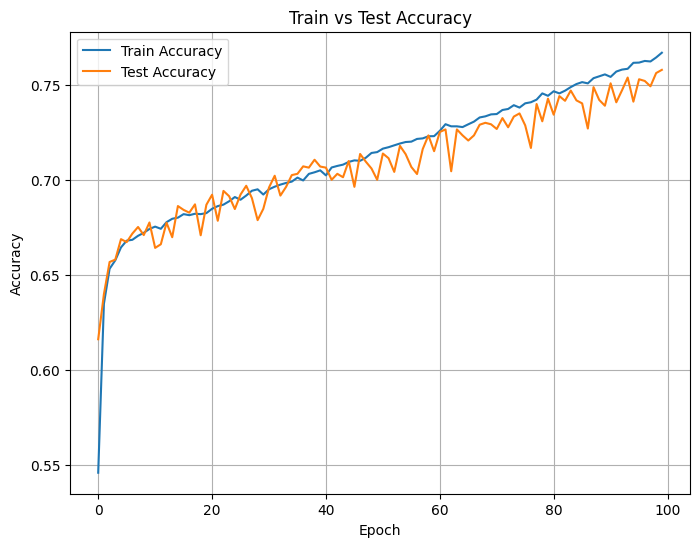

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(y_batch.numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



Test Accuracy: 0.7580663293985385

Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.86      0.82      0.84      1270
             Bipolar       0.75      0.86      0.80      1270
          Depression       0.61      0.46      0.53      1271
              Normal       0.91      0.80      0.85      1271
Personality disorder       0.87      0.88      0.87      1271
              Stress       0.68      0.75      0.71      1271
            Suicidal       0.64      0.73      0.68      1271

            accuracy                           0.76      8895
           macro avg       0.76      0.76      0.76      8895
        weighted avg       0.76      0.76      0.76      8895



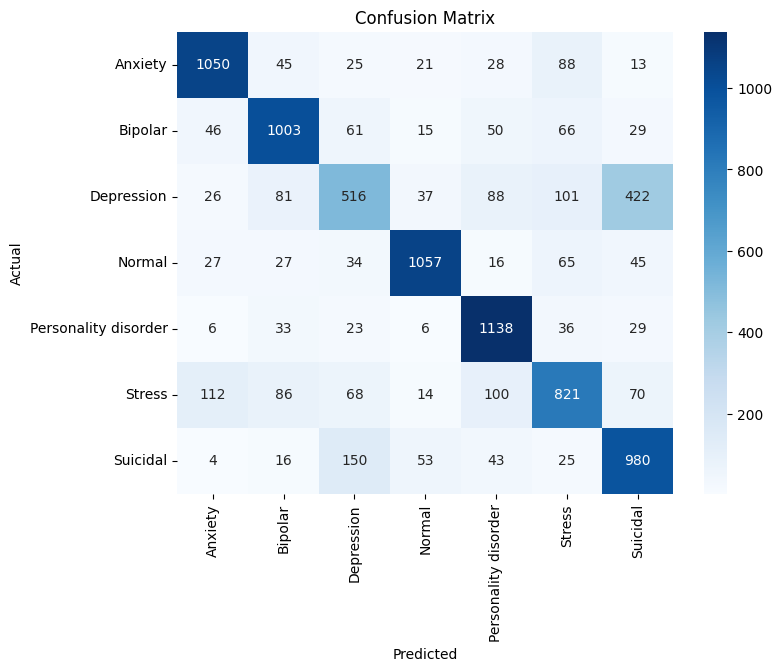

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()